In [ ]:
jupyter nbconvert --to markdown README.ipynb

Based off the work done here:
- CQR: https://arxiv.org/abs/1905.03222
- CQR: poster concise explanation: https://github.com/yromano/cqr/blob/master/poster/CQR_Poster.pdf

### macOS users install `libomp` before running the project:
```bash
brew install libomp

In [ ]:
%pip install prediction_interval

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from prediction_interval import XGBoostCQR, XGBoostQuantileRegressor, XGBoostBootstrap

# Demo of how to use package:

#### Creating dummy data

In [3]:
np.random.seed(42)
n_samples = 1000

# Generate some random features
X1 = np.random.normal(loc=0, scale=1, size=n_samples)
X2 = np.random.normal(loc=5, scale=2, size=n_samples)
X3 = np.random.normal(loc=5, scale=2, size=n_samples)
X4 = np.random.normal(loc=5, scale=2, size=n_samples)
X5 = np.random.normal(loc=5, scale=2, size=n_samples)
X6 = np.random.normal(loc=5, scale=2, size=n_samples)
X7 = np.random.normal(loc=5, scale=2, size=n_samples)

# Create a target variable with some noise
# assume a linear relationship with some noise
y = 3 * X1 + 2 * X2 + np.random.normal(loc=0, scale=1, size=n_samples) +X3+X4+X5+X6+X7

df = pd.DataFrame({
    "Feature1": X1,
    "Feature2": X2,
    "Feature3": X3,
    "Feature4": X4,
    "Feature5": X5,
    "Feature6": X6,
    "Feature7": X7,
    "Target": y
})

print(df.head())
print(df.shape)

   Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0  0.496714  7.798711  3.649643  1.184385  3.273013  4.152481  2.771837   
1 -0.138264  6.849267  4.710963  3.279230  4.937593  4.093172  3.738138   
2  0.647689  5.119261  3.415160  4.172789  5.036034  1.408714  3.115880   
3  1.523030  3.706126  4.384077  8.775375  5.945261  4.339820  3.904008   
4 -0.234153  6.396447  1.212771  6.113106  2.266283  6.465658  4.571699   

      Target  
0  32.904108  
1  32.265157  
2  30.044909  
3  39.096159  
4  33.427409  
(1000, 8)


##### To import data saved locally uncomment the following and add full path to dataset in place of path_to_file...

In [4]:
# # Importing data saved locally:
# path = r"path_to_file..."
# data = pd.read_csv(path)


### Splitting data

In [5]:
X_data = df.copy()
y_data = X_data.pop("Target")
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25)
X_calibration, X_test, y_calibration, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [6]:
xgboost_params = {
    "max_depth": 4,
    "eta": 0.05,
    "gamma": 0.1,
    "subsample": 0.8,
    "min_child_weight": 100,
    "colsample_bytree": 1,
    "alpha": 5,
    "lambda": 0,
    "base_score": 0.57322098
}
cqr_xgboost = XGBoostCQR(
    model_params=xgboost_params,
    num_boost_round=int(100),
    early_stopping_rounds=10,
    alpha=0.9  # coverage probability for the conformal prediction part of CQR - should be set to your final desired coverage level
    )

##### Using grid search to test different coverage probabilities for the quantile regression portion of CQR
###### Grid search is NOT a required step - can skip straight to fitting final PI model
###### The conformal prediction alpha ensures the PIs are padded to maintain the desired coverage probability even with a lower coverage specified for the quantile regression portion

In [7]:
lower_qr_quantile, upper_qr_quantile, conformity_score = cqr_xgboost.cqr_grid_search_alpha(
    [0.1, 0.2, 0.4,],            # lower quantile coverage probability levels
    [0.6, 0.8, 0.9],             # upper quantile coverage probability levels
    X_train.values,         
    y_train.values, 
    X_calibration.values,   # unseen holdout calibration set used for the conformal prediction portion
    y_calibration.values, 
    X_test.values, 
    y_test.values, 
    0.25                    # split size for the training data of the initial quantile regression
    )

Evaluating --- Lower alpha: 0.1 --- Upper alpha 0.6
Evaluating --- Lower alpha: 0.1 --- Upper alpha 0.8
Evaluating --- Lower alpha: 0.1 --- Upper alpha 0.9
Evaluating --- Lower alpha: 0.2 --- Upper alpha 0.6
Evaluating --- Lower alpha: 0.2 --- Upper alpha 0.8
Evaluating --- Lower alpha: 0.2 --- Upper alpha 0.9
Evaluating --- Lower alpha: 0.4 --- Upper alpha 0.6
Evaluating --- Lower alpha: 0.4 --- Upper alpha 0.8
Evaluating --- Lower alpha: 0.4 --- Upper alpha 0.9
best CWC: 2.2498335501828367e-12
best coverage: 0.952
QR Alphas: [0.4, 0.6]
   l_alpha  u_alpha           cwc  coverage  average_PI_width
0      0.1      0.6  3.123635e-12     0.960         19.704405
1      0.1      0.8  4.587595e-12     0.952         16.637457
2      0.1      0.9  7.390271e-12     0.936         16.710157
3      0.2      0.6  4.482768e-12     0.952         17.158796
4      0.2      0.8  3.692294e-12     0.960         16.109138
5      0.2      0.9  7.937115e-12     0.936         15.027287
6      0.4      0.6  2

##### The output identifies the best quantile values for the quantile regression portion of the prediction interval (0.4 and 0.6)
- despite the quantile levels giving a prediction interval width of 0.6-0.4 = 0.2 the overall PI will still have a width of 0.9 due to the alpha defined at the start
##### Using the results of the grid search we can fit the CQR model with the optimum quantile levels

In [8]:
cqr_xgboost.fit(
    X_train.values, 
    y_train.values, 
    X_calibration.values, 
    y_calibration.values, 
    0.25,                   # training/validation data split proportion used in the quantile regression portion 
    0.4,                    # lower quantile value for quantile regression portion
    0.6,                    # lower quantile value for quantile regression portion
    )

Evaluating --- Lower QR quantile: 0.4 --- Upper QR quantile 0.6 --- CQR alpha 0.9


In [9]:
cqr_preds = cqr_xgboost.predict(X_test)
cqr_preds

{'model_40': <xgboost.core.Booster object at 0x000001A4BE092630>, 'model_60': <xgboost.core.Booster object at 0x000001A4BE091F40>}
(np.float64(6.691801754053905), np.float64(6.691801754053905))


{'model_40_predictions': array([23.486837, 18.67393 , 32.484924, 27.112062, 28.803766, 27.276163,
        22.676764, 31.016535, 33.065357, 29.88289 , 29.197748, 23.760366,
        25.238892, 28.017939, 25.820185, 30.838179, 26.705332, 25.86778 ,
        29.041285, 26.21456 , 30.407969, 27.181593, 29.95053 , 23.81866 ,
        30.059622, 29.288862, 28.555567, 28.5591  , 28.319204, 21.84705 ,
        24.585625, 26.863321, 25.627268, 24.067434, 26.742422, 26.236872,
        33.069336, 24.5562  , 30.418066, 27.926493, 21.664396, 23.109285,
        28.026175, 31.024427, 21.150793, 22.963375, 28.087214, 27.088976,
        24.280598, 22.03742 , 22.731644, 31.532808, 22.613436, 20.83436 ,
        29.681917, 29.690145, 28.256884, 30.230074, 31.142015, 29.283438,
        26.716932, 25.042675, 23.072714, 19.717453, 24.86407 , 29.446177,
        31.87668 , 26.152586, 29.279047, 29.858416, 26.830156, 25.162756,
        27.63354 , 19.20571 , 24.69247 , 25.690577, 30.029097, 30.762701,
        18.258

creates a dictionary for the upper and lower prediction interval with the following naming convention: model_{quantile_level}_predictions
- the key value changes respect to the quantile level specified during fit()

In [10]:
pd.DataFrame(cqr_preds).head()

,model_40_predictions,model_60_predictions
0,23.486837,38.722267
1,18.673929,33.717125
2,32.484924,46.950207
3,27.112062,42.872467
4,28.803766,44.487522


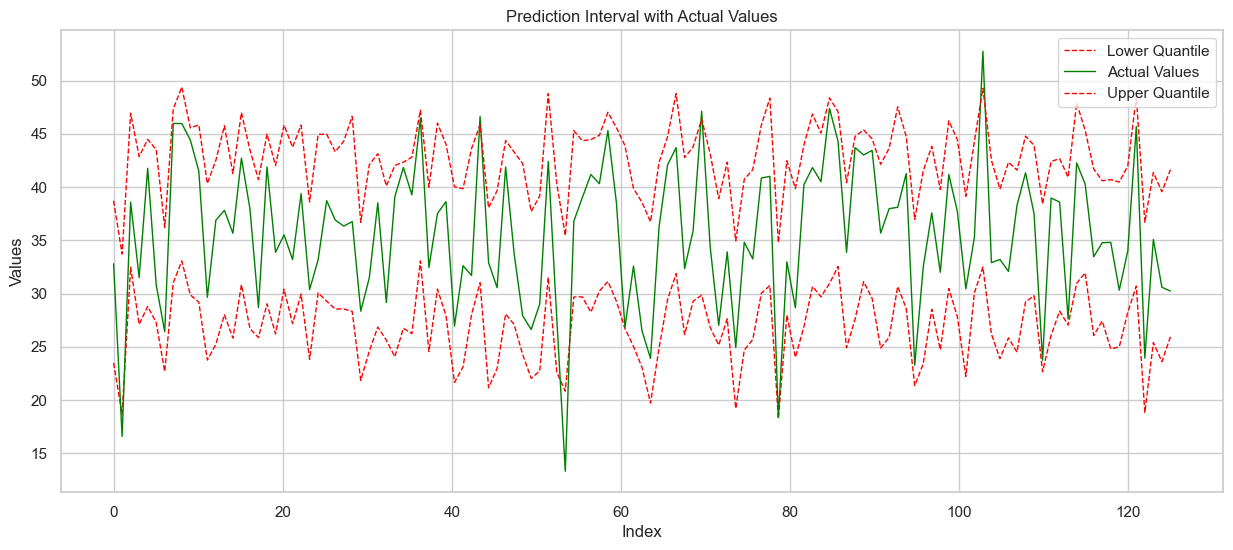

symmetric coverage 0.96
symmetric average_width 15.935728073120117
symmetric cwc 3.719721652657278e-12


In [11]:
lower_quantile_preds = cqr_preds["model_40_predictions"]
upper_quantile_preds = cqr_preds["model_60_predictions"]
cqr_xgboost.plot_pi_line_graph(y_test, lower_quantile_preds, upper_quantile_preds)
print(f"symmetric coverage {cqr_xgboost.coverage(y_test, lower_quantile_preds, upper_quantile_preds)}")
print(f"symmetric average_width {cqr_xgboost.average_width(lower_quantile_preds, upper_quantile_preds)}")
print(f"symmetric cwc {cqr_xgboost.cwc(0.9, y_test, lower_quantile_preds, upper_quantile_preds)}")


### Also have the option for an asymmetric loss function which optimises the upper and lower quantiles separately

In [12]:
# instantiate the model
asymmetric_cqr_xgboost = XGBoostCQR(model_params=xgboost_params,num_boost_round=int(100), alpha=0.90)

# grid search upper and lower quantiles
lower_qr_quantile, upper_qr_quantile, conformity_score = cqr_xgboost.cqr_grid_search_alpha(
    [0.1, 0.2, 0.4,],            # lower quantile coverage probability levels
    [0.6, 0.8, 0.9],             # upper quantile coverage probability levels
    X_train.values,         
    y_train.values, 
    X_calibration.values,   # unseen holdout calibration set used for the conformal prediction portion
    y_calibration.values, 
    X_test.values, 
    y_test.values, 
    0.25                    # split size for the training data of the initial quantile regression
    )

Evaluating --- Lower alpha: 0.1 --- Upper alpha 0.6
Evaluating --- Lower alpha: 0.1 --- Upper alpha 0.8
Evaluating --- Lower alpha: 0.1 --- Upper alpha 0.9
Evaluating --- Lower alpha: 0.2 --- Upper alpha 0.6
Evaluating --- Lower alpha: 0.2 --- Upper alpha 0.8
Evaluating --- Lower alpha: 0.2 --- Upper alpha 0.9
Evaluating --- Lower alpha: 0.4 --- Upper alpha 0.6
Evaluating --- Lower alpha: 0.4 --- Upper alpha 0.8
Evaluating --- Lower alpha: 0.4 --- Upper alpha 0.9
best CWC: 2.2979702687205084e-12
best coverage: 0.944
QR Alphas: [0.1, 0.6]
   l_alpha  u_alpha           cwc  coverage  average_PI_width
0      0.1      0.6  2.297970e-12     0.968         20.983686
1      0.1      0.8  5.785209e-12     0.944         16.820417
2      0.1      0.9  7.639414e-12     0.936         15.943439
3      0.2      0.6  5.581861e-12     0.944         17.615952
4      0.2      0.8  3.708949e-12     0.960         16.003836
5      0.2      0.9  6.238370e-12     0.944         15.047573
6      0.4      0.6  4

The Output for Grid Search shows key metrics (Coverage-Width Criterion, Coverage, average PI width) - best alphas recommended based on lowest CWC which changes based on arbitrary choice of eta parameter in CWC formula (higher eta favours high coverage => wider PIs, lower eta favours narrow PIs => lower coverage) thus for best results experiment with different values of eta or use the full output to also compare coverage and PI width when settling on lower and upper quantile levels. The balance of coverage and PI width will vary based on application

Evaluating --- Lower QR quantile: 0.4 --- Upper QR quantile 0.6 --- CQR alpha 0.9
{'model_40': <xgboost.core.Booster object at 0x000001A4DA37B290>, 'model_60': <xgboost.core.Booster object at 0x000001A4DA3794F0>}
(np.float64(6.199072327530171), np.float64(7.433534967125333))


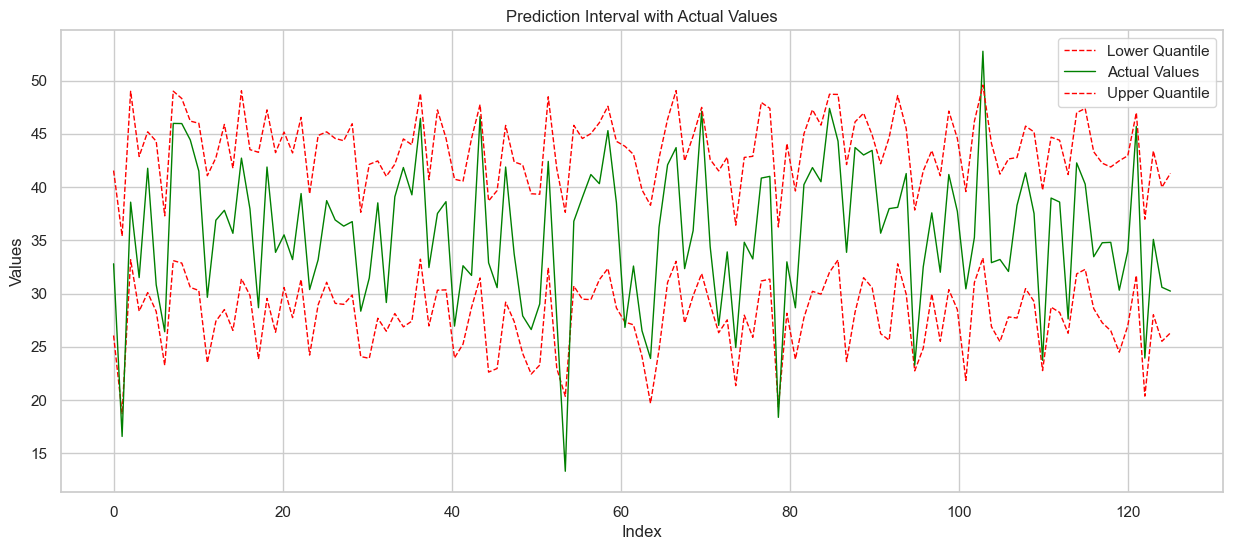

asymmetric coverage 0.96
asymmetric average_width 15.902301788330078
asymmetric cwc 3.725008720146514e-12


In [13]:
# fit the model
asymmetric_cqr_xgboost.fit(
    X_train.values,
    y_train.values,
    X_calibration.values, 
    y_calibration.values, 0.25, 
    lower_qr_quantile=0.4, 
    upper_qr_quantile=0.6, 
    conformity_score_method="asymmetric"
    )
# make predictions
asym_cqr_preds = asymmetric_cqr_xgboost.predict(X_test)     
# access the lower and upper prediction interval values for the X_test data
asym_lower_quantile_preds = asym_cqr_preds["model_40_predictions"]
asym_upper_quantile_preds = asym_cqr_preds["model_60_predictions"]
# plot the prediction interval against the actual y_test values
asymmetric_cqr_xgboost.plot_pi_line_graph(y_test, asym_lower_quantile_preds, asym_upper_quantile_preds)
# print out some key metrics evaluating the prediction interval
print(f"asymmetric coverage {asymmetric_cqr_xgboost.coverage(y_test, asym_lower_quantile_preds, asym_upper_quantile_preds)}")
print(f"asymmetric average_width {asymmetric_cqr_xgboost.average_width(asym_lower_quantile_preds, asym_upper_quantile_preds)}")
print(f"asymmetric cwc {asymmetric_cqr_xgboost.cwc(0.9, y_test, asym_lower_quantile_preds, asym_upper_quantile_preds)}")

Results in a marginally lower coverage probability but a narrower average PI width

### XGBoost Quantile Regression Demo

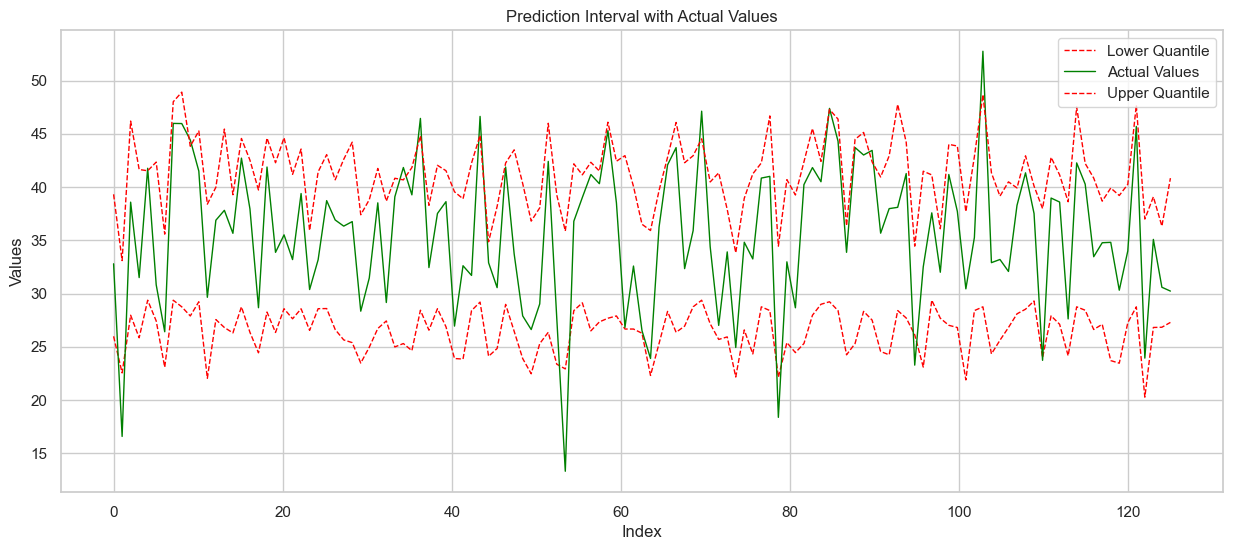

asymmetric coverage 0.888
asymmetric average_width 14.869775772094727
asymmetric cwc 3.3716176135545774e-11


In [14]:
qr_xgboost = XGBoostQuantileRegressor(
    model_params=xgboost_params,
    num_boost_round=int(100),
    early_stopping_rounds=10,
    quantiles=[0.05, 0.95]  # coverage probability for the conformal prediction part of CQR - should be set to your final desired coverage level
    )
qr_xgboost.fit(X_train, y_train, validation_size=0.25)
qr_preds = qr_xgboost.predict(X_test)
# access the lower and upper prediction interval values for the X_test data
lower_qr_preds = qr_preds["model_5_predictions"]
upper_qr_preds = qr_preds["model_95_predictions"]
# plot the prediction interval against the actual y_test values
asymmetric_cqr_xgboost.plot_pi_line_graph(y_test, lower_qr_preds, upper_qr_preds)
# print out some key metrics evaluating the prediction interval
print(f"asymmetric coverage {asymmetric_cqr_xgboost.coverage(y_test, lower_qr_preds, upper_qr_preds)}")
print(f"asymmetric average_width {asymmetric_cqr_xgboost.average_width(lower_qr_preds, upper_qr_preds)}")
print(f"asymmetric cwc {asymmetric_cqr_xgboost.cwc(0.9, y_test, lower_qr_preds, upper_qr_preds)}")

----- Training model 1 / 100 -----
----- Training model 2 / 100 -----
----- Training model 3 / 100 -----
----- Training model 4 / 100 -----
----- Training model 5 / 100 -----
----- Training model 6 / 100 -----
----- Training model 7 / 100 -----
----- Training model 8 / 100 -----
----- Training model 9 / 100 -----
----- Training model 10 / 100 -----
----- Training model 11 / 100 -----
----- Training model 12 / 100 -----
----- Training model 13 / 100 -----
----- Training model 14 / 100 -----
----- Training model 15 / 100 -----
----- Training model 16 / 100 -----
----- Training model 17 / 100 -----
----- Training model 18 / 100 -----
----- Training model 19 / 100 -----
----- Training model 20 / 100 -----
----- Training model 21 / 100 -----
----- Training model 22 / 100 -----
----- Training model 23 / 100 -----
----- Training model 24 / 100 -----
----- Training model 25 / 100 -----
----- Training model 26 / 100 -----
----- Training model 27 / 100 -----
----- Training model 28 / 100 -----
-

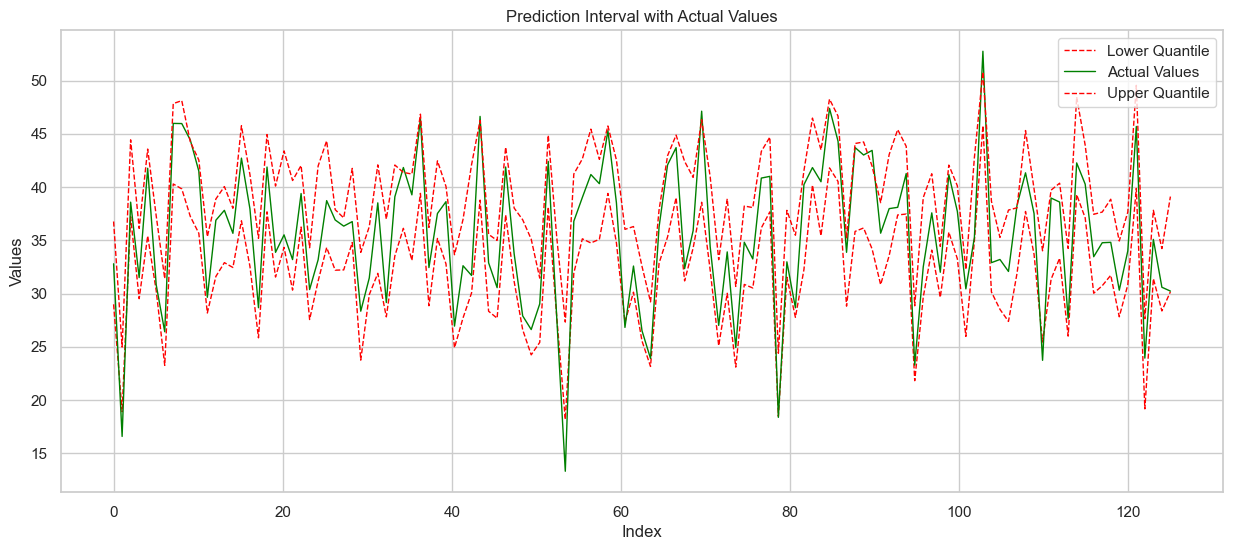

Bootstrap coverage 0.896
Bootstrap average_width 7.640153408050537
Bootstrap cwc 3.4321849985369016e-11


In [ ]:
bootstrap = XGBoostBootstrap(
    model_params={},
    num_boost_round=int(100),
    alpha=0.98
    )
bootstrap.fit(X_train, y_train, n_bootstrap=100, sample_size_ratio=0.7)
bs_preds = bootstrap.predict(X_test)
# access the lower and upper prediction interval values for the X_test data
lower_qr_preds = bs_preds["model_1_predictions"]
upper_qr_preds = bs_preds["model_99_predictions"]


# plot the prediction interval against the actual y_test values
bootstrap.plot_pi_line_graph(y_test, lower_qr_preds, upper_qr_preds)
# print out some key metrics evaluating the prediction interval
print(f"Bootstrap coverage {bootstrap.coverage(y_test, lower_qr_preds, upper_qr_preds)}")
print(f"Bootstrap average_width {bootstrap.average_width(lower_qr_preds, upper_qr_preds)}")
print(f"Bootstrap cwc {bootstrap.cwc(0.9, y_test, lower_qr_preds, upper_qr_preds)}")

Bootstrap undercovers with the default parameters - introducing randomness via XGBoosts hyperparameters (subsample, colsample_bytree, colsample_bylevel  , ...) may reduce this effect

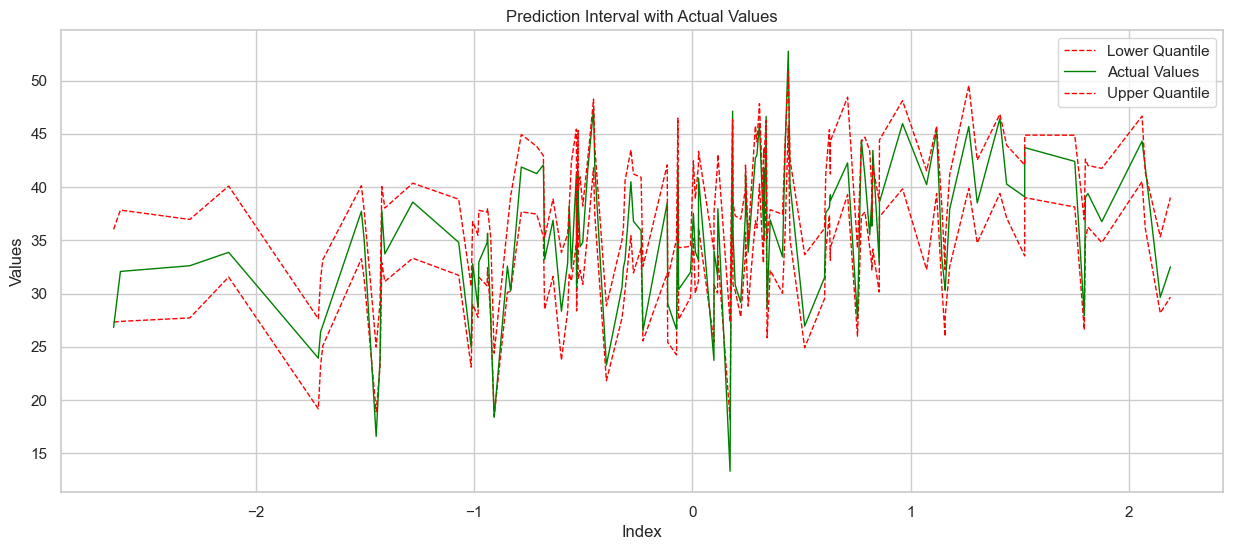

In [19]:
bootstrap.plot_pi_line_graph(y_test, lower_qr_preds, upper_qr_preds, X_test["Feature1"])

###

In [ ]:
bootstrap.plot_coverage_probability_binned(y_test, lower_qr_preds, upper_qr_preds, x=X_test["Feature1"])

In [ ]:
bootstrap.plot_pi_width(lower_qr_preds, upper_qr_preds, x=X_test["Feature1"])